# California Housing Price Prediction with PyTorch


In [54]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.nn import functional as F
from torch.autograd import Variable
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt

## 1. Data Loading and Preprocessing


### 1.1 Load the California Housing Dataset

In [55]:
data = fetch_california_housing()


### 1.2 Data Exploration

In [56]:
california_housing = pd.DataFrame(data.data, columns=data.feature_names)
california_housing['MedHouseVal'] = data.target
california_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [57]:
california_housing.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
MedHouseVal,0


### 1.3 Data Splitting and Scaling


In [58]:
X = california_housing.drop('MedHouseVal', axis=1)
y = california_housing['MedHouseVal']

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Initial split: Train+Validation and Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## 2. Model Building


### 2.1 Define the Linear Regression Model

In [60]:
class Linear_Regression(nn.Module):
    def __init__(self, X_features, output_dim):
        super(Linear_Regression, self).__init__()
        self.weights_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(X_features, 32), requires_grad=True))
        self.bias_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(32), requires_grad=True))

        self.weights_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(32, 16), requires_grad=True))
        self.bias_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(16), requires_grad=True))

        self.weights_of_hidden_layer3 = nn.Parameter(torch.tensor(torch.rand(16, 8), requires_grad=True))
        self.bias_of_hidden_layer3 = nn.Parameter(torch.tensor(torch.rand(8), requires_grad=True))

        self.weights_of_output_layer = nn.Parameter(torch.tensor(torch.rand(8, 1), requires_grad=True))
        self.bias_of_output_layer = nn.Parameter(torch.tensor(torch.rand(1), requires_grad=True))

    def forward(self, x):
        hidden_layer1_input = torch.matmul(x, self.weights_of_hidden_layer1) + self.bias_of_hidden_layer1
        hidden_layer1_output = F.relu(hidden_layer1_input)

        hidden_layer2_input = torch.matmul(hidden_layer1_output, self.weights_of_hidden_layer2) + self.bias_of_hidden_layer2
        hidden_layer2_output = F.relu(hidden_layer2_input)

        hidden_layer3_input = torch.matmul(hidden_layer2_output, self.weights_of_hidden_layer3) + self.bias_of_hidden_layer3
        hidden_layer3_output = F.relu(hidden_layer3_input)

        final_output = torch.matmul(hidden_layer3_output, self.weights_of_output_layer) + self.bias_of_output_layer

        return final_output



## 3. Model Training

### 3.1 Define the Training Function

In [61]:
def train_model(model, train_data, val_data, n_epoch, training_batch_size, val_batch_size, loss_fn, optimizer):
        # init training data loader
        train_loader = DataLoader(dataset=train_data, batch_size=training_batch_size, shuffle=True)
        val_loader = DataLoader(dataset=val_data, batch_size=val_batch_size, shuffle=True)
        # Training loop
        train_losses = []
        val_losses = []

        for epoch in range(n_epoch):
            total_train_epoch_loss = 0
            total_val_epoch_loss = 0
            for x_batch, y_batch in train_loader:  # Process mini-batches
                model.train()

                # Forward pass
                yhat = model(x_batch)
                loss = loss_fn(yhat, y_batch)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_train_epoch_loss += loss.item()

            avg_train_loss = total_train_epoch_loss / len(train_loader)
            # Store train loss
            train_losses.append(loss.item())
            print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}", end = '')

            with torch.no_grad():
                for X_val, y_val in val_loader:
                    model.eval()
                    yhat = model(X_val)
                    val_loss = loss_fn(yhat, y_val)
                    total_val_epoch_loss += val_loss.item()

            avg_val_loss = total_val_epoch_loss / len(val_loader)
            # Store train loss
            val_losses.append(val_loss.item())
            print(f"    Validation Loss: {avg_val_loss:.4f}")

        return train_losses, val_losses

### 3.2 Create Datasets and Train the Model

In [62]:
def get_dataset(X, y):
    dataset = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y.values).float())
    return dataset

In [63]:
train_data = get_dataset(X_train, y_train)
val_data = get_dataset(X_val, y_val)
test_data = get_dataset(X_test, y_test)

In [64]:
model1 = Linear_Regression(X_train.shape[1], 1);
optimizer = optim.SGD(model1.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
train_losses_of_model1, val_losses_of_model1 = train_model(model1, train_data, val_data, n_epoch=30, training_batch_size=int(len(X_train)/10), val_batch_size=int(len(X_val)/10), loss_fn=loss_fn, optimizer=optimizer)

<ipython-input-60-13a13e686e09>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(X_features, 32), requires_grad=True))
<ipython-input-60-13a13e686e09>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bias_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(32), requires_grad=True))
<ipython-input-60-13a13e686e09>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(32, 16), requires_grad=True))
<ip

Epoch 1, Train Loss: 83982.1003    Validation Loss: 19.1910


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4128])) that is different to the input size (torch.Size([4128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2, Train Loss: 15.9647    Validation Loss: 12.7913
Epoch 3, Train Loss: 11.0559    Validation Loss: 8.6360
Epoch 4, Train Loss: 7.3261    Validation Loss: 6.0362
Epoch 5, Train Loss: 5.2159    Validation Loss: 4.3433
Epoch 6, Train Loss: 3.9910    Validation Loss: 3.2223
Epoch 7, Train Loss: 2.9727    Validation Loss: 2.5231
Epoch 8, Train Loss: 2.3608    Validation Loss: 2.0827
Epoch 9, Train Loss: 1.8992    Validation Loss: 1.8414
Epoch 10, Train Loss: 1.6691    Validation Loss: 1.6651
Epoch 11, Train Loss: 1.5689    Validation Loss: 1.5519
Epoch 12, Train Loss: 1.4665    Validation Loss: 1.4769
Epoch 13, Train Loss: 1.3932    Validation Loss: 1.4413
Epoch 14, Train Loss: 1.4341    Validation Loss: 1.4111
Epoch 15, Train Loss: 1.2556    Validation Loss: 1.3958
Epoch 16, Train Loss: 1.4220    Validation Loss: 1.3951
Epoch 17, Train Loss: 1.3471    Validation Loss: 1.3840
Epoch 18, Train Loss: 1.3046    Validation Loss: 1.3792
Epoch 19, Train Loss: 1.2870    Validation Loss: 1.37

## 4. Model Evaluation

### 4.1 Define the Evaluation Function

In [65]:
# Evaluation function
def evaluate_model(model, test_data):

    test_loader = DataLoader(dataset=test_data, batch_size=len(test_data), shuffle=True)
    model.eval()

    mse_loss_fn = nn.MSELoss(reduction='mean')
    mae_loss_fn = nn.L1Loss(reduction='mean')

    mse_total = 0
    mae_total = 0
    num_samples = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_pred = model(X_test)
            mse_total += mse_loss_fn(y_pred, y_test).item()
            mae_total += mae_loss_fn(y_pred, y_test).item()
            #num_samples += y_test.size(0)

    #mse = mse_total / num_samples
    #mae = mae_total / num_samples
    return mse_total, mae_total


### 4.2 Evaluate Model Performance


In [66]:
mse_of_model1, mae_of_model1 = evaluate_model(model1, test_data)
print(f"Mean Squared Error on test data: {mse_of_model1}")
print(f"Mean Absoulute Error on test data: {mae_of_model1}")

Mean Squared Error on test data: 1.3104913234710693
Mean Absoulute Error on test data: 0.9009730219841003


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([4128])) that is different to the input size (torch.Size([4128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


### 4.3 Plot training vs. validation loss

In [67]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses, title="Training vs. Validation Loss" ):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')

    # Adjust y-axis to focus on relevant range
    min_loss = min(min(train_losses), min(val_losses))
    max_loss = max(max(train_losses), max(val_losses))
    plt.ylim([0, min(max_loss * 1.1, 100)])  # Set upper limit dynamically, clamp to 10 for visibility

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


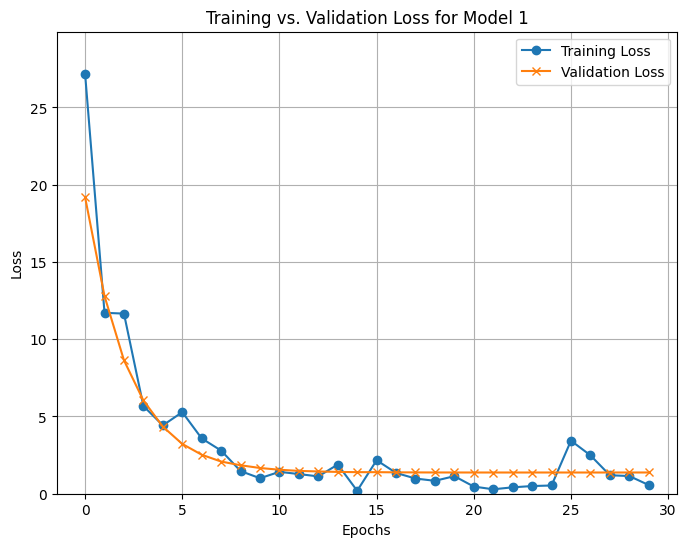

In [79]:
plot_loss(train_losses_of_model1, val_losses_of_model1, title='Training vs. Validation Loss for Model 1')

## 5. Model Experimentation

### 5.1 Experiment with Different Hyperparameters

In [69]:
model2 = Linear_Regression(X_train.shape[1], 1);
optimizer = optim.SGD(model2.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
train_losses_of_model2, val_losses_of_model2 = train_model(model2, train_data, val_data, n_epoch=50, training_batch_size=int(len(X_train)/5), val_batch_size=int(len(X_val)/5), loss_fn=loss_fn, optimizer=optimizer)

<ipython-input-60-13a13e686e09>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(X_features, 32), requires_grad=True))
<ipython-input-60-13a13e686e09>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bias_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(32), requires_grad=True))
<ipython-input-60-13a13e686e09>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(32, 16), requires_grad=True))
<ip

Epoch 1, Train Loss: 791333.3086    Validation Loss: 977.4553
Epoch 2, Train Loss: 885.1897    Validation Loss: 767.3894
Epoch 3, Train Loss: 692.9411    Validation Loss: 602.7520
Epoch 4, Train Loss: 545.8328    Validation Loss: 473.3625
Epoch 5, Train Loss: 432.3684    Validation Loss: 371.3369
Epoch 6, Train Loss: 332.7320    Validation Loss: 292.1636
Epoch 7, Train Loss: 267.9065    Validation Loss: 229.1856
Epoch 8, Train Loss: 203.8212    Validation Loss: 180.6160
Epoch 9, Train Loss: 165.6685    Validation Loss: 141.7911
Epoch 10, Train Loss: 130.6894    Validation Loss: 111.2951
Epoch 11, Train Loss: 100.9546    Validation Loss: 87.6123
Epoch 12, Train Loss: 78.6020    Validation Loss: 69.1695
Epoch 13, Train Loss: 62.9644    Validation Loss: 54.5379
Epoch 14, Train Loss: 49.1937    Validation Loss: 43.1499
Epoch 15, Train Loss: 37.5283    Validation Loss: 34.3858
Epoch 16, Train Loss: 32.2938    Validation Loss: 27.1439
Epoch 17, Train Loss: 24.9334    Validation Loss: 21.5565

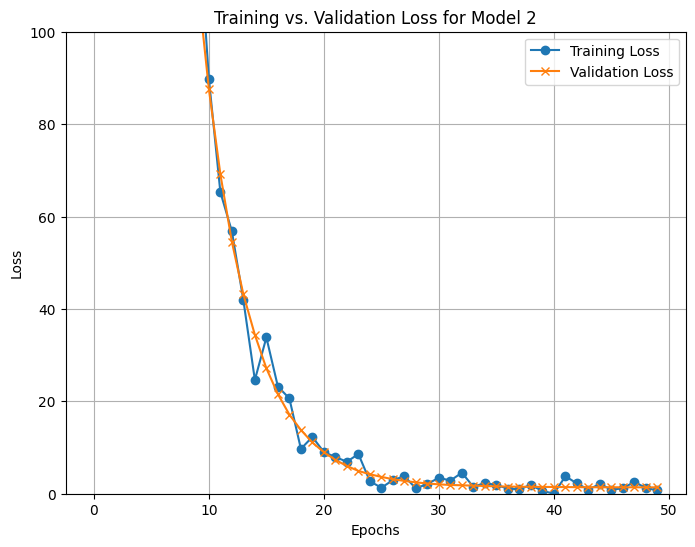

In [78]:
plot_loss(train_losses_of_model2, val_losses_of_model2, title='Training vs. Validation Loss for Model 2')

In [75]:
# Evaluate the model on the test set
mse_of_model2, mae_of_model2 = evaluate_model(model2, test_data)
print(f"Mean Squared Error on test data: {mse_of_model2}")
print(f"Mean Absoulute Error on test data: {mae_of_model2}")

Mean Squared Error on test data: 1.3218121528625488
Mean Absoulute Error on test data: 0.9260721206665039


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4128])) that is different to the input size (torch.Size([4128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([4128])) that is different to the input size (torch.Size([4128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [72]:
model3 = Linear_Regression(X_train.shape[1], 1);
optimizer = optim.SGD(model3.parameters(), lr=0.1)
loss_fn = nn.MSELoss()
train_losses_of_model3, val_losses_of_model3 = train_model(model3, train_data, val_data, n_epoch=50, training_batch_size=int(len(X_train)), val_batch_size=int(len(X_val)), loss_fn=loss_fn, optimizer=optimizer)

<ipython-input-60-13a13e686e09>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(X_features, 32), requires_grad=True))
<ipython-input-60-13a13e686e09>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bias_of_hidden_layer1 = nn.Parameter(torch.tensor(torch.rand(32), requires_grad=True))
<ipython-input-60-13a13e686e09>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights_of_hidden_layer2 = nn.Parameter(torch.tensor(torch.rand(32, 16), requires_grad=True))
<ip

Epoch 1, Train Loss: 575548.8125    Validation Loss: 7652.5703
Epoch 2, Train Loss: 7649.8140    Validation Loss: 4898.5713
Epoch 3, Train Loss: 4896.3569    Validation Loss: 3135.9270
Epoch 4, Train Loss: 3134.1450    Validation Loss: 2007.7649
Epoch 5, Train Loss: 2006.3301    Validation Loss: 1285.6857
Epoch 6, Train Loss: 1284.5282    Validation Loss: 823.5107
Epoch 7, Train Loss: 822.5748    Validation Loss: 527.6832
Epoch 8, Train Loss: 526.9247    Validation Loss: 338.3252
Epoch 9, Train Loss: 337.7087    Validation Loss: 217.1134
Epoch 10, Train Loss: 216.6104    Validation Loss: 139.5196
Epoch 11, Train Loss: 139.1075    Validation Loss: 89.8451
Epoch 12, Train Loss: 89.5057    Validation Loss: 58.0418
Epoch 13, Train Loss: 57.7605    Validation Loss: 37.6784
Epoch 14, Train Loss: 37.4436    Validation Loss: 24.6383
Epoch 15, Train Loss: 24.4408    Validation Loss: 16.2868
Epoch 16, Train Loss: 16.1189    Validation Loss: 10.9370
Epoch 17, Train Loss: 10.7930    Validation Los

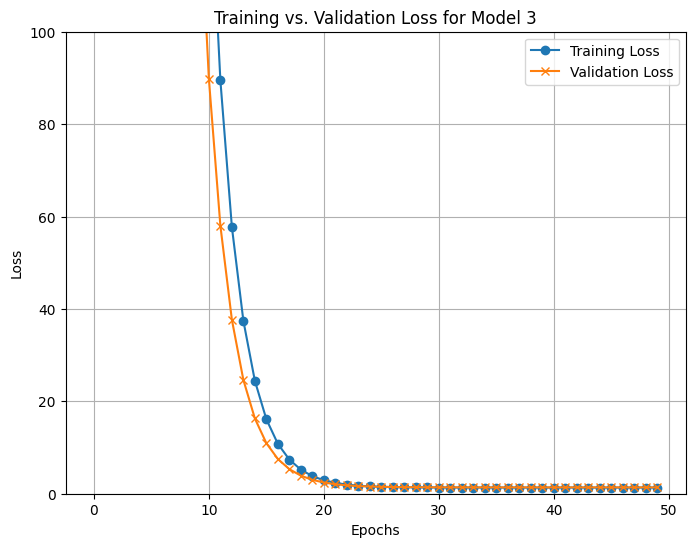

In [77]:
plot_loss(train_losses_of_model3, val_losses_of_model3, title='Training vs. Validation Loss for Model 3')

In [74]:
mse_of_model3, mae_of_model3 = evaluate_model(model2, test_data)
print(f"Mean Squared Error on test data: {mse_of_model3}")
print(f"Mean Absoulute Error on test data: {mae_of_model3}")

Mean Squared Error on test data: 1.3218120336532593
Mean Absoulute Error on test data: 0.9260720610618591
